## 1. The Statcast revolution
<p><img style="float: left;margin:5px 20px 5px 1px" src="https://assets.datacamp.com/production/project_250/img/judge_wide.jpg"></p>
<p>This is Aaron Judge. Judge is one of the physically largest players in Major League Baseball standing 6 feet 7 inches (2.01 m) tall and weighing 282 pounds (128 kg). He also hit the <a href="https://www.mlb.com/news/aaron-judge-sets-statcast-exit-velocity-record/c-235640846">hardest home run</a> ever recorded. How do we know this? <strong>Statcast</strong>.</p>
<p>Statcast is a state-of-the-art tracking system that uses high-resolution cameras and radar equipment to measure the precise location and movement of baseballs and baseball players. Introduced in 2015 to all 30 major league ballparks, Statcast data is revolutionizing the game. Teams are engaging in an "arms race" of data analysis, hiring analysts left and right in an attempt to gain an edge over their competition. This <a href="https://www.youtube.com/watch?v=9rOKGKhQe8U">video</a> describing the system is incredible.</p>
<p><strong>In this notebook</strong>, we're going to wrangle, analyze, and visualize Statcast data to compare Mr. Judge and another (extremely large) teammate of his. Let's start by loading the data into our Notebook. There are two CSV files, <code>judge.csv</code> and <code>stanton.csv</code>, both of which contain Statcast data for 2015-2017. We'll use pandas DataFrames to store this data. Let's also load our data visualization libraries, matplotlib and seaborn.</p>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.vq import kmeans, vq
%matplotlib inline

# Load Aaron Judge's Statcast data
judge = pd.read_csv("/home/riasat/Downloads/project/A New Era of Data Analysis in Baseball/datasets/judge.csv")

# Load Giancarlo Stanton's Statcast data
stanton = pd.read_csv("/home/riasat/Downloads/project/A New Era of Data Analysis in Baseball/datasets/stanton.csv")

## 2. What can Statcast measure?
<p>The better question might be, what can't Statcast measure?</p>
<blockquote>
  <p>Starting with the pitcher, Statcast can measure simple data points such as velocity. At the same time, Statcast digs a whole lot deeper, also measuring the release point and spin rate of every pitch.</p>
  <p>Moving on to hitters, Statcast is capable of measuring the exit velocity, launch angle and vector of the ball as it comes off the bat. From there, Statcast can also track the hang time and projected distance that a ball travels.</p>
</blockquote>
<p>Let's inspect the last five rows of the <code>judge</code> DataFrame. You'll see that each row represents one pitch thrown to a batter. You'll also see that some columns have esoteric names. If these don't make sense now, don't worry. The relevant ones will be explained as necessary.</p>

In [3]:
# Display all columns (pandas will collapse some columns if we don't set this option)
pd.set_option('display.max_columns', None)

# Display the last five rows of the Aaron Judge file
judge.tail()


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,pos2_person_id,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pos1_person_id,pos2_person_id.1,pos3_person_id,pos4_person_id,pos5_person_id,pos6_person_id,pos7_person_id,pos8_person_id,pos9_person_id,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number
3431,CH,2016-08-13,85.6,-1.9659,5.9113,Aaron Judge,592450,542882,NaN,ball,NaN,NaN,NaN,NaN,14.0,NaN,R,R,R,NYY,TB,B,NaN,NaN,0,0,2016,-0.379108,0.370567,0.739,1.442,NaN,NaN,NaN,0,5,Bot,NaN,NaN,NaN,NaN,571912.0,NaN,160813_144259,6.960,-124.371,-4.756,-2.821,23.634,-30.220,3.93,1.82,NaN,NaN,NaN,84.459,1552.0,5.683,448611,542882.0,571912.0,543543.0,523253.0,446334.0,622110.0,545338.0,595281.0,543484.0,54.8144,0.00,0.000,NaN,NaN,NaN,NaN,NaN,36,1
3432,CH,2016-08-13,87.6,-1.9318,5.9349,Aaron Judge,592450,542882,home_run,hit_into_play_score,NaN,NaN,NaN,NaN,4.0,Aaron Judge homers (1) on a fly ball to center...,R,R,R,NYY,TB,X,NaN,fly_ball,1,2,2016,-0.295608,0.320400,-0.419,3.273,NaN,NaN,NaN,2,2,Bot,130.45,14.58,NaN,NaN,571912.0,NaN,160813_135833,4.287,-127.452,-0.882,-1.972,24.694,-30.705,4.01,1.82,446.0,108.8,27.410,86.412,1947.0,5.691,448611,542882.0,571912.0,543543.0,523253.0,446334.0,622110.0,545338.0,595281.0,543484.0,54.8064,0.98,1.937,2.0,1.0,0.0,3.0,6.0,14,4
3433,CH,2016-08-13,87.2,-2.0285,5.8656,Aaron Judge,592450,542882,NaN,ball,NaN,NaN,NaN,NaN,14.0,NaN,R,R,R,NYY,TB,B,NaN,NaN,0,2,2016,-0.668575,0.198567,0.561,0.960,NaN,NaN,NaN,2,2,Bot,NaN,NaN,NaN,NaN,571912.0,NaN,160813_135815,7.491,-126.665,-5.862,-6.393,21.952,-32.121,4.01,1.82,NaN,NaN,NaN,86.368,1761.0,5.721,448611,542882.0,571912.0,543543.0,523253.0,446334.0,622110.0,545338.0,595281.0,543484.0,54.7770,0.00,0.000,NaN,NaN,NaN,NaN,NaN,14,3
3434,CU,2016-08-13,79.7,-1.7108,6.1926,Aaron Judge,592450,542882,NaN,foul,NaN,NaN,NaN,NaN,4.0,NaN,R,R,R,NYY,TB,S,NaN,NaN,0,1,2016,0.397442,-0.614133,-0.803,2.742,NaN,NaN,NaN,2,2,Bot,NaN,NaN,NaN,NaN,571912.0,NaN,160813_135752,1.254,-116.062,0.439,5.184,21.328,-39.866,4.01,1.82,9.0,55.8,-24.973,77.723,2640.0,5.022,448611,542882.0,571912.0,543543.0,523253.0,446334.0,622110.0,545338.0,595281.0,543484.0,55.4756,0.00,0.000,NaN,NaN,NaN,NaN,1.0,14,2
3435,FF,2016-08-13,93.2,-1.8476,6.0063,Aaron Judge,592450,542882,NaN,called_strike,NaN,NaN,NaN,NaN,8.0,NaN,R,R,R,NYY,TB,S,NaN,NaN,0,0,2016,-0.823050,1.623300,-0.273,2.471,NaN,NaN,NaN,2,2,Bot,NaN,NaN,NaN,NaN,571912.0,NaN,160813_135736,5.994,-135.497,-6.736,-9.360,26.782,-13.446,4.01,1.82,NaN,NaN,NaN,92.696,2271.0,6.068,448611,542882.0,571912.0,543543.0,523253.0,446334.0,622110.0,545338.0,595281.0,543484.0,54.4299,0.00,0.000,NaN,NaN,NaN,NaN,NaN,14,1


## 3. Aaron Judge and Giancarlo Stanton, prolific sluggers
<p><img style="float: left;margin:5px 20px 5px 1px" src="https://assets.datacamp.com/production/project_250/img/stanton_wide.jpg"></p>
<p>This is Giancarlo Stanton. He is also a very large human being, standing 6 feet 6 inches tall and weighing 245 pounds. Despite not wearing the same jersey as Judge in the pictures provided, in 2018 they will be teammates on the New York Yankees. They are similar in a lot of ways, one being that they hit a lot of home runs. Stanton and Judge led baseball in home runs in 2017, with <a href="https://www.youtube.com/watch?v=tJ6Bz5P6dg4">59</a> and <a href="https://www.youtube.com/watch?v=Gw3pFHMM9fk">52</a>, respectively. These are exceptional totals - the player in third "only" had 45 home runs.</p>
<p>Stanton and Judge are also different in many ways. One is <a href="http://m.mlb.com/glossary/statcast/batted-ball-event">batted ball events</a>, which is any batted ball that produces a result. This includes outs, hits, and errors. Next, you'll find the counts of batted ball events for each player in 2017. The frequencies of other events are quite different.</p>

In [4]:
# All of Aaron Judge's batted ball events in 2017
judge_events_2017 = judge.loc[judge['game_year']==2017].events
print("Aaron Judge batted ball event totals, 2017:")
print(judge_events_2017.value_counts())

# All of Giancarlo Stanton's batted ball events in 2017
stanton_events_2017 = stanton.loc[stanton['game_year']==2017].events
print("\nGiancarlo Stanton batted ball event totals, 2017:")
print(stanton_events_2017.value_counts())

Aaron Judge batted ball event totals, 2017:
strikeout                    207
field_out                    146
walk                         116
single                        75
home_run                      52
double                        24
grounded_into_double_play     15
intent_walk                   11
force_out                     11
hit_by_pitch                   5
fielders_choice_out            4
sac_fly                        4
field_error                    4
triple                         3
strikeout_double_play          1
Name: events, dtype: int64

Giancarlo Stanton batted ball event totals, 2017:
field_out                    239
strikeout                    161
single                        77
walk                          72
home_run                      59
double                        32
grounded_into_double_play     13
intent_walk                   13
force_out                      7
hit_by_pitch                   7
field_error                    5
sac_fly             

## 4. Analyzing home runs with Statcast data
<p>So Judge walks and strikes out more than Stanton. Stanton flies out more than Judge. But let's get into their hitting profiles in more detail. Two of the most groundbreaking Statcast metrics are launch angle and exit velocity:</p>
<ul>
<li><a href="http://m.mlb.com/glossary/statcast/launch-angle">Launch angle</a>: the vertical angle at which the ball leaves a player's bat</li>
<li><a href="http://m.mlb.com/glossary/statcast/exit-velocity">Exit velocity</a>: the speed of the baseball as it comes off the bat</li>
</ul>
<p>This new data has changed the way teams value both hitters and pitchers. Why? As per the <a href="https://www.washingtonpost.com/graphics/sports/mlb-launch-angles-story/?utm_term=.8d088d31f098">Washington Post</a>:</p>
<blockquote>
  <p>Balls hit with a high launch angle are more likely to result in a hit. Hit fast enough and at the right angle, they become home runs.</p>
</blockquote>
<p>Let's look at exit velocity vs. launch angle and let's focus on home runs only (2015-2017). The first two plots show data points. The second two show smoothed contours to represent density.</p>

/home/riasat/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Giancarlo Stanton\nHome Runs, 2015-2017')

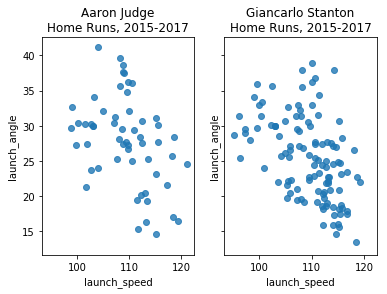

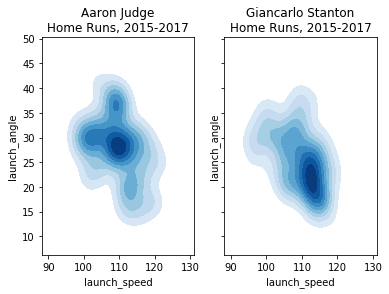

In [5]:
# Filter to include home runs only
judge_hr = judge.loc[judge['events']=='home_run']
stanton_hr = stanton.loc[stanton['events']=='home_run']

# Create a figure with two scatter plots of launch speed vs. launch angle, one for each player's home runs
fig1, axs1 = plt.subplots(ncols=2, sharex=True, sharey=True)
sns.regplot(x=judge_hr.launch_speed, y=judge_hr.launch_angle, fit_reg=False, color='tab:blue', data=judge_hr, ax=axs1[0]).set_title('Aaron Judge\nHome Runs, 2015-2017')
sns.regplot(x=stanton_hr.launch_speed, y=stanton_hr.launch_angle, fit_reg=False, color='tab:blue', data=stanton_hr, ax=axs1[1]).set_title('Giancarlo Stanton\nHome Runs, 2015-2017')

# Create a figure with two KDE plots of launch speed vs. launch angle, one for each player's home runs
fig2, axs2 = plt.subplots(ncols=2, sharex=True, sharey=True)
sns.kdeplot(judge_hr.launch_speed,judge_hr.launch_angle, cmap="Blues", shade=True, shade_lowest=False, ax=axs2[0]).set_title('Aaron Judge\nHome Runs, 2015-2017')
sns.kdeplot(stanton_hr.launch_speed,stanton_hr.launch_angle, cmap="Blues", shade=True, shade_lowest=False, ax=axs2[1]).set_title('Giancarlo Stanton\nHome Runs, 2015-2017')

## 5. Home runs by pitch velocity
<p>It appears that Stanton hits his home runs slightly lower and slightly harder than Judge, though this needs to be taken with a grain of salt given the small sample size of home runs.</p>
<p>Not only does Statcast measure the velocity of the ball coming off of the bat, it measures the velocity of the ball coming out of the pitcher's hand and begins its journey towards the plate. We can use this data to compare Stanton and Judge's home runs in terms of pitch velocity. Next you'll find box plots displaying the five-number summaries for each player: minimum, first quartile, median, third quartile, and maximum.</p>

Text(0.5, 1.0, 'Home Runs, 2015-2017')

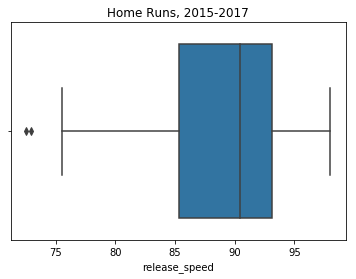

In [6]:
# Combine the Judge and Stanton home run DataFrames for easy boxplot plotting
judge_stanton_hr = pd.concat([judge_hr,stanton_hr])

# Create a boxplot that describes the pitch velocity of each player's home runs
sns.boxplot(judge_stanton_hr.release_speed).set_title('Home Runs, 2015-2017')

## 6. Home runs by pitch location (I)
<p>So Judge appears to hit his home runs off of faster pitches than Stanton. We might call Judge a fastball hitter. Stanton appears agnostic to pitch speed and likely pitch movement since slower pitches (e.g. curveballs, sliders, and changeups) tend to have more break. Statcast <em>does</em> track pitch movement and type but let's move on to something else: <strong>pitch location</strong>. Statcast tracks the zone the pitch is in when it crosses the plate. The zone numbering looks like this (from the catcher's point of view):</p>
<p><img style="margin:5px 20px 5px 1px; width:20%;" src="https://assets.datacamp.com/production/project_250/img/zone.png"></p>
<p>We can plot this using a 2D histogram. For simplicity, let's only look at strikes, which gives us a 9x9 grid. We can view each zone as coordinates on a 2D plot, the bottom left corner being (1,1) and the top right corner being (3,3). Let's set up a function to assign x-coordinates to each pitch.</p>

In [7]:
def assign_x_coord(row):
    """
    Assigns an x-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Left third of strike zone
    if row.zone in [1, 4, 7]:
        return 1;
        
    # Middle third of strike zone
    if row.zone in [2, 5, 8]:
        return 2
        
    # Right third of strike zone
    if row.zone in [3, 6, 9]:
        return 3

## 7. Home runs by pitch location (II)
<p>And let's do the same but for y-coordinates.</p>

In [8]:
def assign_y_coord(row):
    """
    Assigns a y-coordinate to Statcast's strike zone numbers. Zones 11, 12, 13,
    and 14 are ignored for plotting simplicity.
    """
    # Upper third of strike zone
    if row.zone in [1,2,3]:
        return 3
    # Middle third of strike zone
    if row.zone in [4,5,6]:
        return 2
    # Lower third of strike zone
    if row.zone in [7,8,9]:
        return 1

## 8. Aaron Judge's home run zone
<p>Now we can apply the functions we've created then construct our 2D histograms. First, for Aaron Judge (again, for pitches in the strike zone that resulted in home runs).</p>

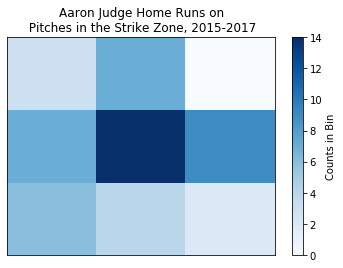

In [9]:
# Zones 11, 12, 13, and 14 are to be ignored for plotting simplicity
judge_strike_hr = judge_hr.copy().loc[judge_hr.zone <= 9]

# Assign Cartesian coordinates to pitches in the strike zone for Judge home runs
judge_strike_hr['zone_x'] = judge_strike_hr.apply(assign_x_coord,axis=1)
judge_strike_hr['zone_y'] = judge_strike_hr.apply(assign_y_coord,axis=1)

# Plot Judge's home run zone as a 2D histogram with a colorbar
plt.hist2d(judge_strike_hr.zone_x,judge_strike_hr.zone_y, bins = 3, cmap='Blues')
plt.title('Aaron Judge Home Runs on\n Pitches in the Strike Zone, 2015-2017')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.set_label('Counts in Bin')

## 9. Giancarlo Stanton's home run zone
<p>And now for Giancarlo Stanton.</p>

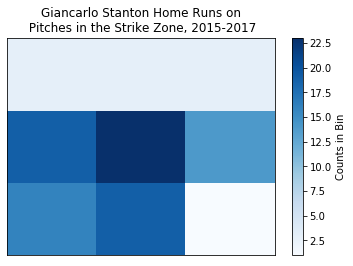

In [10]:
# Zones 11, 12, 13, and 14 are to be ignored for plotting simplicity
stanton_strike_hr = stanton_hr.copy().loc[stanton_hr.zone <= 9]

# Assign Cartesian coordinates to pitches in the strike zone for Stanton home runs
stanton_strike_hr['zone_x']=stanton_strike_hr.apply(assign_x_coord,axis=1)
stanton_strike_hr['zone_y']=stanton_strike_hr.apply(assign_y_coord,axis=1)

# Plot Stanton's home run zone as a 2D histogram with a colorbar
plt.hist2d(stanton_strike_hr.zone_x,stanton_strike_hr.zone_y, bins = 3, cmap='Blues')
plt.title('Giancarlo Stanton Home Runs on\n Pitches in the Strike Zone, 2015-2017')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
cb = plt.colorbar()
cb.set_label('Counts in Bin')

## 10. Should opposing pitchers be scared?
<p>A few takeaways:</p>
<ul>
<li>Stanton does not hit many home runs on pitches in the upper third of the strike zone.</li>
<li>Like pretty much every hitter ever, both players love pitches in the horizontal and vertical middle of the plate.</li>
<li>Judge's least favorite home run pitch appears to be high-away while Stanton's appears to be low-away.</li>
<li>If we were to describe Stanton's home run zone, it'd be middle-inside. Judge's home run zone is much more spread out.</li>
</ul>
<p>The grand takeaway from this whole exercise: Aaron Judge and Giancarlo Stanton are not identical despite their superficial similarities. In terms of home runs, their launch profiles, as well as their pitch speed and location preferences, are different.</p>
<p>Should opposing pitchers still be scared?</p>

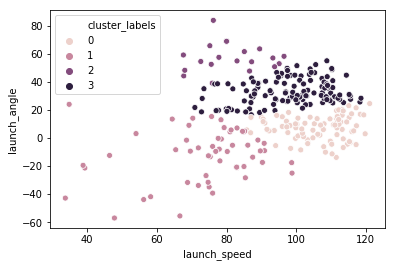

In [11]:
judge_hr_so = judge[(judge['events']=='home_run')|(judge['events']=='strikeout')|(judge['events']=='field_out')|(judge['events']=='single')]

x_coordinates=judge_hr_so['launch_speed']
y_coordinates=judge_hr_so['launch_angle']
x = x_coordinates.dropna()
y = y_coordinates.dropna()

df = pd.DataFrame({'launch_speed':x,'launch_angle':y})
centroids,_=kmeans(df,4)
df['cluster_labels'],_=vq(df,centroids)
sns.scatterplot(x='launch_speed',y='launch_angle',hue='cluster_labels',data=df)
plt.show()